# Prodigy InfoTech Internship: Task 3

Build a decision tree classifier to predict whether a customer will purchase a product or service based on their demographic and behavioral data. Use a dataset such as the Bank Marketing dataset from the UCI Machine Learning Repository.

Sample Dataset: [Bank Marketing](https://archive.ics.uci.edu/dataset/222/bank+marketing)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context='notebook', style='whitegrid', palette='muted')

## Understand the shape of the data

In [2]:
df = pd.read_csv('data/Bank.csv', sep=';')

In [3]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [6]:
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


In [7]:
df.duplicated().sum()

0

## Data Cleaning

In [8]:
df = df.rename(columns={'y': 'subscribed'})
df['subscribed'] = df['subscribed'].map({'yes': 'Subscribed', 'no': 'Not Subscribed'})

In [9]:
categorical_cols = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
df[categorical_cols] = (df[categorical_cols].apply(lambda x: x.str.title())
                                            .astype('category'))

binary_cols = ['default', 'housing', 'loan']
df[binary_cols] = df[binary_cols] == 'yes'

In [10]:
cols_with_outliers = ['age', 'balance', 'duration', 'campaign']

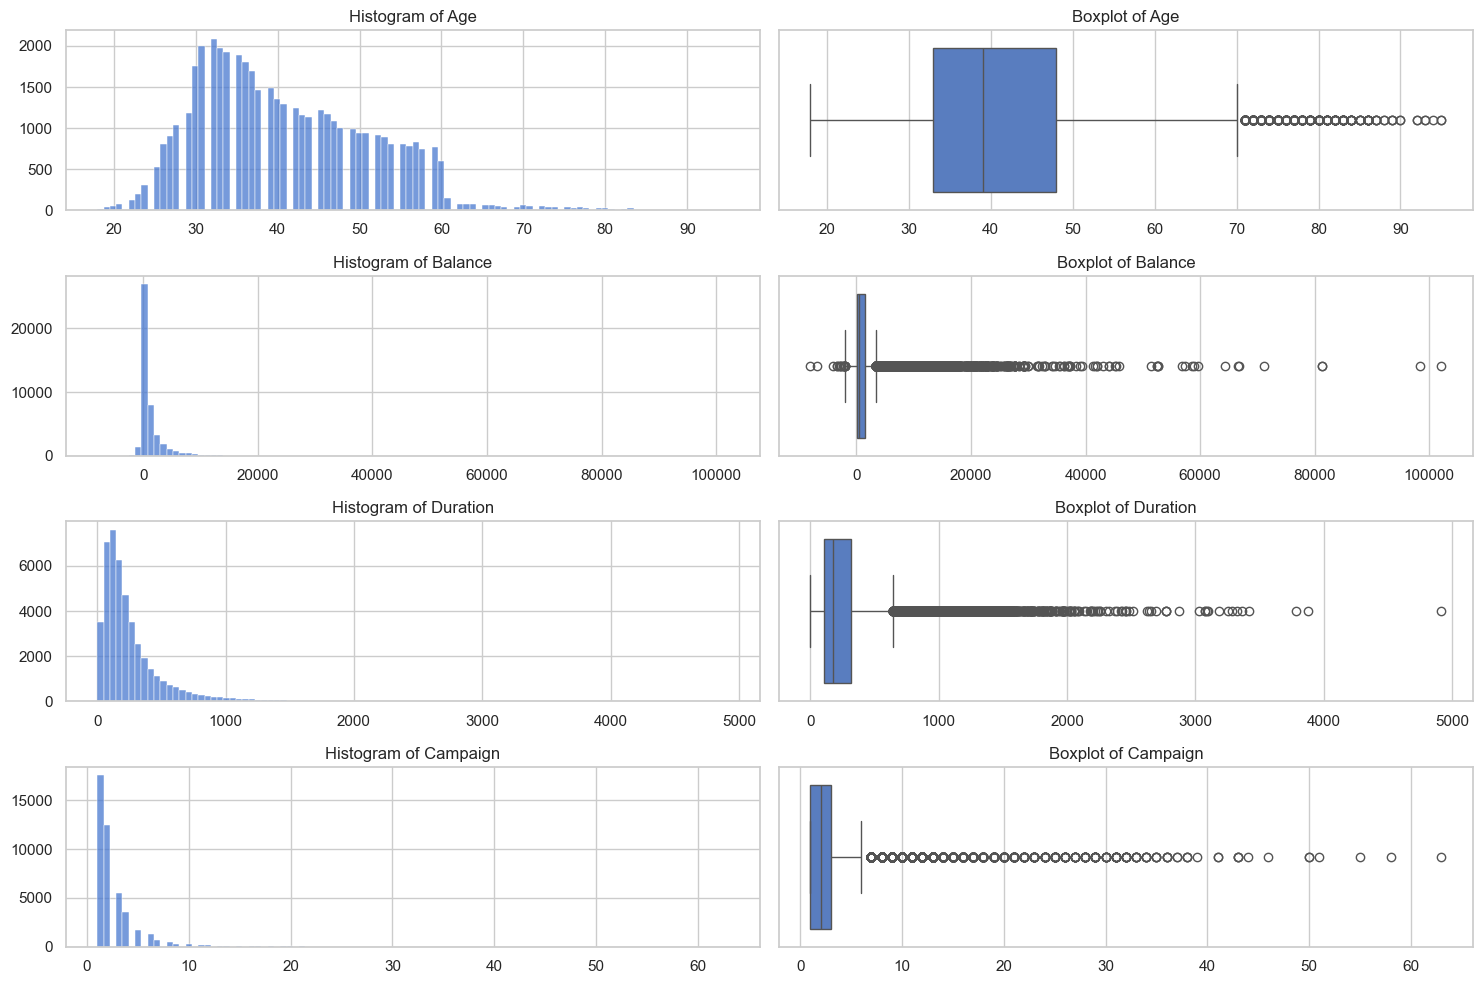

In [11]:
fig, axes = plt.subplots(4, 2, figsize=(15, 10))

for i, col in enumerate(cols_with_outliers):
    hist_ax, box_ax = axes[i, :]

    sns.histplot(data=df, x=col, bins=100, ax=hist_ax)
    hist_ax.set_title(f'Histogram of {col.title()}')
    hist_ax.set_xlabel('')
    hist_ax.set_ylabel('')

    sns.boxplot(data=df, x=col, ax=box_ax)
    box_ax.set_title(f'Boxplot of {col.title()}')
    box_ax.set_xlabel('')
    box_ax.set_ylabel('')

plt.tight_layout()
plt.show();

In [12]:
def remove_outliers(df, columns):
    df_outliers_removed = df.copy()

    for col in columns:
        Q1 = df_outliers_removed[col].quantile(0.25)
        Q3 = df_outliers_removed[col].quantile(0.75)

        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df_outliers_removed = df_outliers_removed[
            (df_outliers_removed[col] >= lower_bound) &
            (df_outliers_removed[col] <= upper_bound)
        ]

    return df_outliers_removed

df = remove_outliers(df, cols_with_outliers)

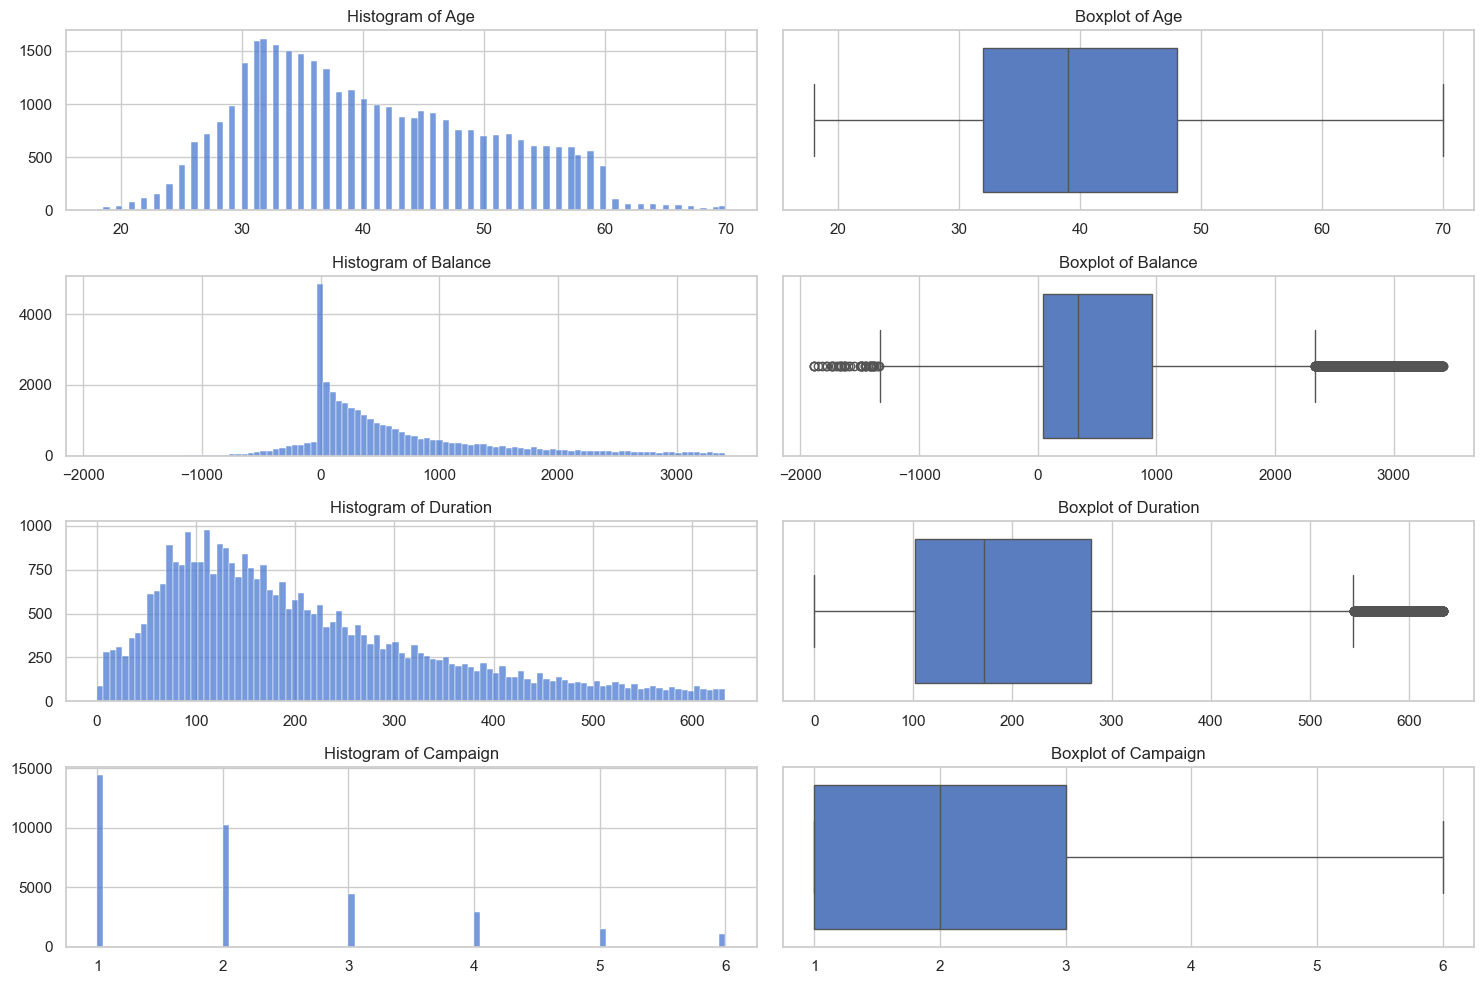

In [13]:
fig, axes = plt.subplots(4, 2, figsize=(15, 10))

for i, col in enumerate(cols_with_outliers):
    hist_ax, box_ax = axes[i, :]

    sns.histplot(data=df, x=col, bins=100, ax=hist_ax)
    hist_ax.set_title(f'Histogram of {col.title()}')
    hist_ax.set_xlabel('')
    hist_ax.set_ylabel('')

    sns.boxplot(data=df, x=col, ax=box_ax)
    box_ax.set_title(f'Boxplot of {col.title()}')
    box_ax.set_xlabel('')
    box_ax.set_ylabel('')

plt.tight_layout()
plt.show();

## Data Exploration

In [14]:
num_cols = df.select_dtypes('number').columns.tolist()
bool_cols = df.select_dtypes(bool).columns.tolist()
cat_cols = df.select_dtypes('category').columns.tolist()

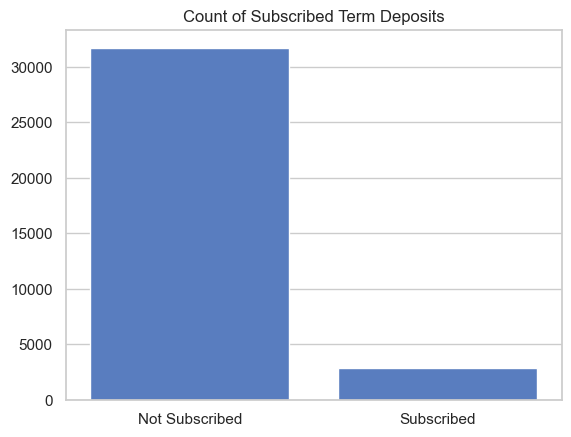

In [15]:
sns.countplot(data=df, x='subscribed');

plt.title('Count of Subscribed Term Deposits')
plt.xlabel('')
plt.ylabel('')

plt.show();

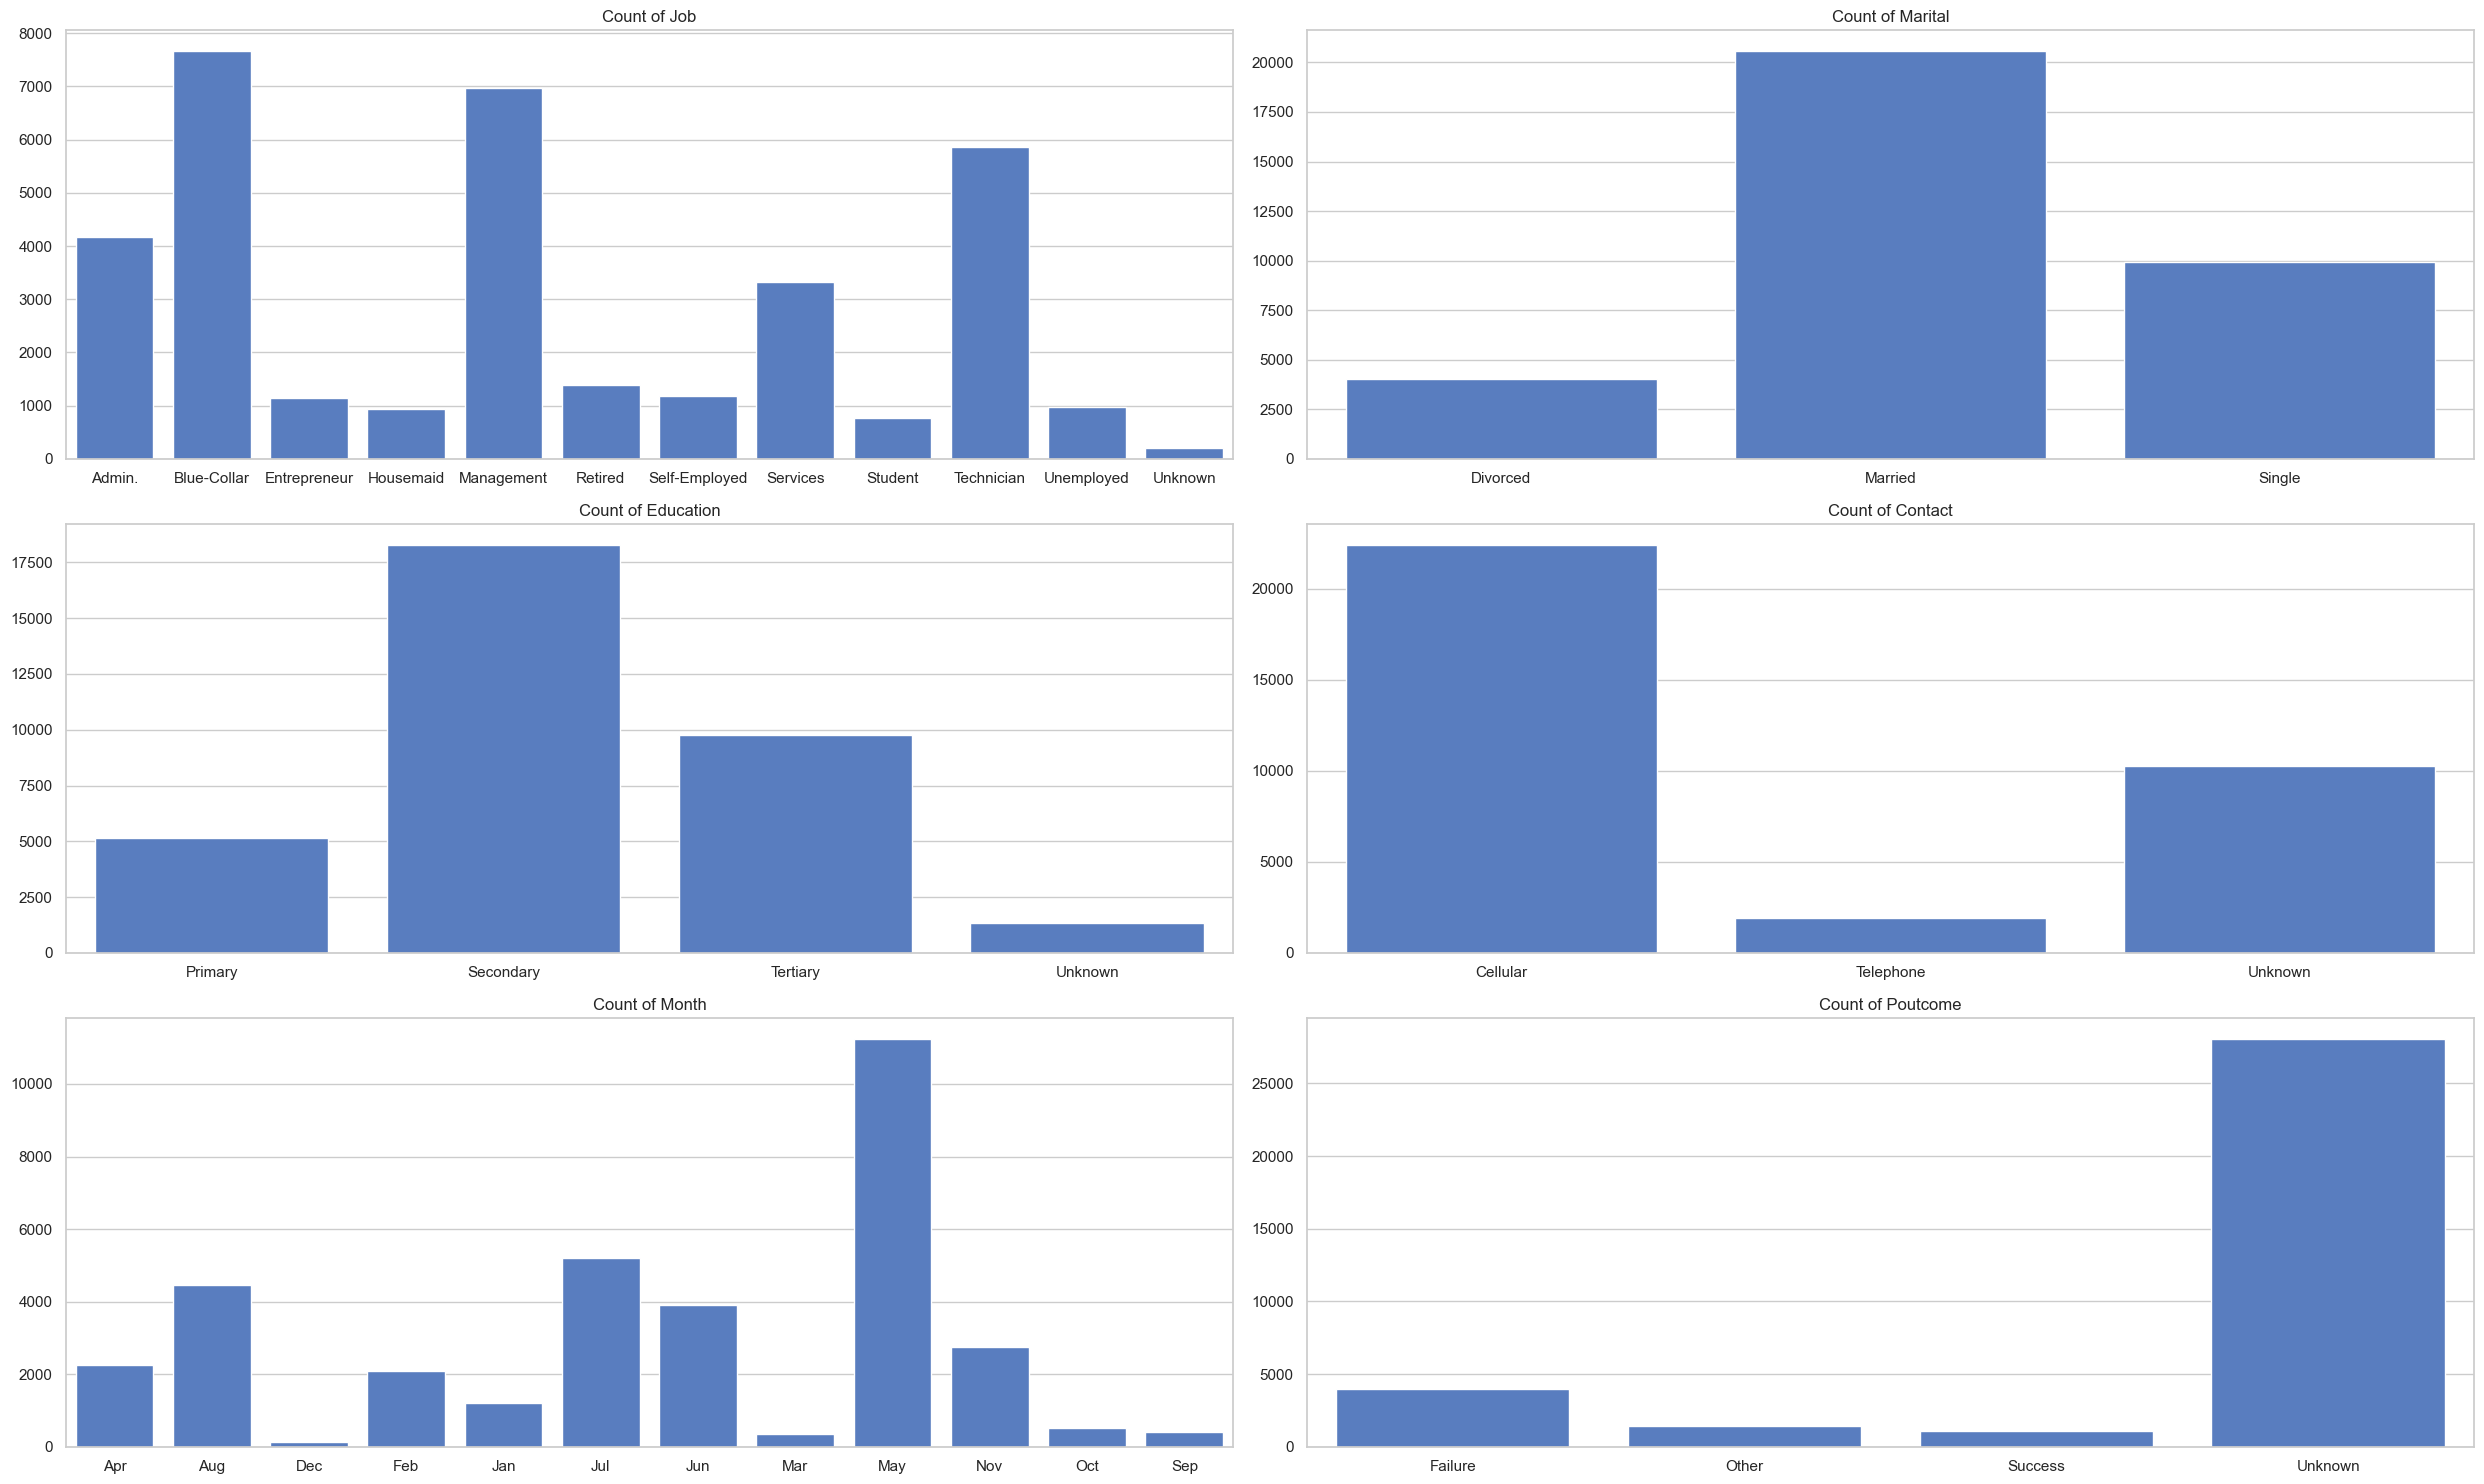

In [16]:
fig, axes = plt.subplots(3, 2, figsize=(25, 15))

for feature, ax in zip(cat_cols, axes.flatten()):
    sns.countplot(data=df, x=feature, ax=ax)

    ax.set_title(f'Count of {feature.title()}')
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show();

## Data Preprocessing for Model

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import RandomOverSampler

In [18]:
X = df.drop(columns='subscribed')
y = df['subscribed']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

In [19]:
num_vars = df.select_dtypes('number').columns.tolist()
cat_vars = df.select_dtypes('category').columns.tolist()

In [20]:
preprocessing_pipeline = ColumnTransformer([
    ('numerical', StandardScaler(), num_vars),
    ('categorical', OneHotEncoder(), cat_vars),
])

X_train = preprocessing_pipeline.fit_transform(X_train)
X_test = preprocessing_pipeline.transform(X_test)

In [21]:
sampler = RandomOverSampler(random_state=42)

X_train, y_train = sampler.fit_resample(X_train, y_train)

## Basic Model Building

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [23]:
%%time

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

CPU times: user 1.06 s, sys: 4.49 ms, total: 1.07 s
Wall time: 1.09 s


DecisionTreeClassifier(random_state=42)

In [24]:
y_pred = model.predict(X_test)

accuracy = model.score(X_test, y_test)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2%}')
print(f'Classification Report:\n{report}')

Accuracy: 90.09%
Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.95      0.95      0.95      6343
    Subscribed       0.40      0.41      0.40       570

      accuracy                           0.90      6913
     macro avg       0.67      0.68      0.67      6913
  weighted avg       0.90      0.90      0.90      6913



## Model Tuning

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

In [26]:
param_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

In [27]:
scorer = make_scorer(f1_score, pos_label='Subscribed')

In [28]:
base_model = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=base_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring=scorer,
                           verbose=1,
                           n_jobs=-1)

In [29]:
%%time

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
CPU times: user 1.73 s, sys: 198 ms, total: 1.93 s
Wall time: 23.8 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring=make_scorer(f1_score, response_method='predict', pos_label=Subscribed),
             verbose=1)

In [30]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)

print(f'Best Accuracy: {accuracy:.2%}')
print(f'Best Parameters:\n{best_params}')

Best Accuracy: 90.11%
Best Parameters:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [31]:
y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred)

print(f'Classification Report:\n{report}')

Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.95      0.95      0.95      6343
    Subscribed       0.40      0.41      0.41       570

      accuracy                           0.90      6913
     macro avg       0.67      0.68      0.68      6913
  weighted avg       0.90      0.90      0.90      6913



## Results

In [32]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

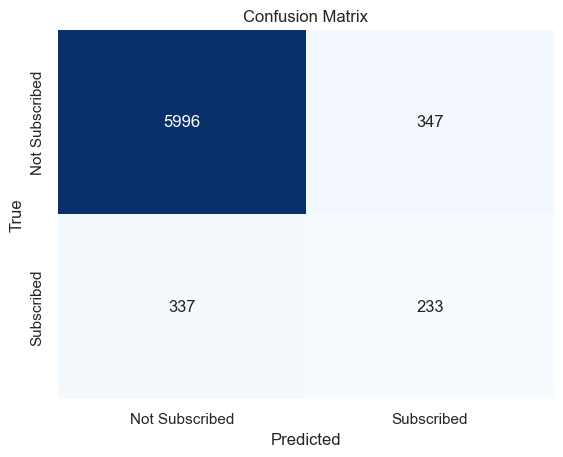

In [35]:
conf_matrix = confusion_matrix(y_test, y_pred)
labels = best_model.classes_

sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            cbar=False,
            xticklabels=labels,
            yticklabels=labels)


plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show();